In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [41]:
import numpy as np
import os
import datetime

In [3]:
import scrinet.workflow.generators

In [155]:
M = 60

q_array = np.linspace(1, 2, 50)
(
    times,
    ts_amp,
    ts_phase,
    _,
    _,
    _,
    coords,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q_array, M, n_cores=2, t_min=-1000
)

q_random = np.random.uniform(1, 5, 50)
(
    _,
    ts2_amp,
    ts2_phase,
    _,
    _,
    _,
    coords2,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q_random, M, n_cores=2, t_min=-1000
)

In [110]:
plt.figure()
plt.plot(q_array, np.ones_like(q_array), "o", markerfacecolor="None", label='set1')
plt.plot(q_random, np.ones_like(q_random), "x", label='set2')
plt.legend()
plt.xlabel("mass-ratio")

Text(0.5, 0, 'mass-ratio')

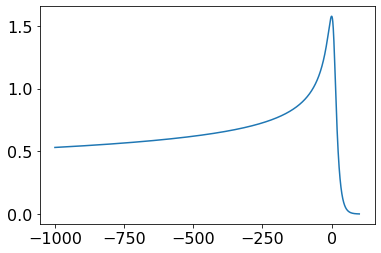

In [116]:
plt.figure()
plt.plot(times, ts_amp[0])

# dev classes

In [8]:
# taken from Galley's rompy
# import numpy as np
class _IteratedModifiedGramSchmidt(object):
    """Iterated modified Gram-Schmidt algorithm for building an orthonormal basis.
    Algorithm from Hoffman, `Iterative Algorithms for Gram-Schmidt Orthogonalization`.
    """

    def __init__(self, inner):
        self.inner = inner

    def add_basis(self, h, basis, a=0.5, max_iter=3):
        """Given a function, h, find the corresponding basis function orthonormal to all previous ones"""
        norm = self.inner.norm(h)
        e = h/norm
        #r = np.zeros(len(basis))
        flag, ctr = 0, 1
        while flag == 0:
            #s = np.zeros(len(basis))
            for b in basis:
                # for ii, bb in enumerate(basis):
                # s[ii] = self.inner.dot(bb, e, self.inner_type)
                # e -= bb*s[ii]
                e -= b*self.inner.dot(b, e)
            #r += s
            new_norm = self.inner.norm(e)
            #r[0] = new_norm
            # Iterate, if necessary
            if new_norm/norm <= a:
                norm = new_norm
                ctr += 1
                if ctr > max_iter:
                    print(
                        ">>> Warning(Max number of iterations reached) Basis may not be orthonormal.", flush=True)
                    flag = 1
            else:
                flag = 1

        # print r

        return [e/new_norm, new_norm]
        # return [e/new_norm, new_norm, r]

    def make_basis(self, hs, norms=False, a=0.5, max_iter=3):
        """Given a set of functions, hs, find the corresponding orthonormal set of basis functions."""

        dim = np.shape(hs)
        #basis = np.zeros(dim, dtype=hs.dtype)
        basis = np.zeros_like(hs)
        basis[0] = self.inner.normalize(hs[0])
        # R = np.zeros((dim[0],dim[0]), dtype=hs.dtype)
        # R[0][0] = self.inner.norm(hs[0], self.inner_type)
        if norms:
            norm = np.zeros(dim[0], dtype='double')
            norm[0] = self.inner.norm(hs[0])

        for ii in range(1, dim[0]):
            if norms:
                basis[ii], norm[ii] = self.add_basis(
                    hs[ii], basis[:ii], a=a, max_iter=max_iter)
                #basis[ii], norm[ii], R[ii-1][:ii] = self.add_basis(hs[ii], basis[:ii], a=a, max_iter=max_iter)
            else:
                basis[ii], _ = self.add_basis(
                    hs[ii], basis[:ii], a=a, max_iter=max_iter)
                #basis[ii], _, R[ii-1][:ii] = self.add_basis(hs[ii], basis[:ii], a=a, max_iter=max_iter)

        if norms:
            return [np.array(basis), norm]
            # return [np.array(basis), norm, R]
        else:
            return np.array(basis)
            # return [np.array(basis), R]


In [9]:
import rompy as rp

In [10]:
integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal")

In [11]:
imgs = _IteratedModifiedGramSchmidt(integration)

In [12]:
imgs

In [13]:
basis = imgs.make_basis(ts_amp)

In [14]:
basis.shape

(50, 5000)

In [15]:
plt.figure()
plt.plot(times, basis[0])
plt.plot(times, basis[1])
# plt.xlim(-100,100)

In [16]:
seed_basis = integration.normalize(ts_amp[0]).reshape(1,-1)

In [17]:
seed_basis.shape

(1, 5000)

In [18]:
new_element, _ = imgs.add_basis(ts_amp[-1], seed_basis)

In [19]:
new_element.shape

(5000,)

In [20]:
new_basis = np.row_stack((seed_basis, new_element))

In [21]:
new_basis.shape

(2, 5000)

In [22]:
plt.figure()
plt.plot(times, new_basis[0])
plt.plot(times, new_basis[1])
# plt.plot(times, basis[1], ls='--')
# plt.xlim(-100,100)

In [23]:
# now i need to implement the greedy search
# mainly based on rompy's ReducedBasis class

In [24]:
# this has the helper methods to compute projects
class _ReducedBasis(object):

    def __init__(self, inner):
        self.inner = inner

    def malloc(self, Nbasis, Npoints, Nquads, Nmodes=1, dtype='complex'):
        """Allocate memory for numpy arrays used for making reduced basis"""
        self.errors = malloc('double', Nbasis)
        self.indices = malloc('int', Nbasis)
        if Nmodes == 1:
            self.basis = malloc(dtype, Nbasis, Nquads)
        elif Nmodes > 1:
            self.basis = malloc(dtype, Nbasis, Nmodes, Nquads)
        else:
            raise Exception("Expected positive number of modes.")
        self.basisnorms = malloc('double', Nbasis)
        self.alpha = malloc(dtype, Nbasis, Npoints)

    def _alpha(self, e, h):
        """Inner product of a basis function e with a function h:
            alpha(e,h) = <e, h>
        """
        return self.inner.dot(e, h)

    def alpha_arr(self, e, hs):
        """Inner products of a basis function e with an array of functions hs"""
        return np.array([self._alpha(e, hh) for hh in hs])

    def proj_error_from_basis(self, basis, h):
        """Square of the projection error of a function h on basis"""
        norm = self.inner.norm(h).real
        dim = len(basis[:, 0])
        ans = 0.
        for ii in range(dim):
            ans += np.abs(self._alpha(basis[ii], h))**2
        return norm**2-ans
        # return norm**2-np.sum(np.abs(self._alpha(basis[ii], h))**2 for ii in range(dim))

    def proj_errors_from_basis(self, basis, hs):
        """Square of the projection error of functions hs on basis"""
        #norms = np.real([self.inner.norm(hh, self.inner_type) for hh in hs])
        #dim = len(basis[:,0])
        # return [norms**2-np.sum(np.abs(self._alpha(basis[ii], hh))**2 for ii in range(dim)) for hh in hs]
        return [self.proj_error_from_basis(basis, hh) for hh in hs]

    def proj_mismatch_from_basis(self, basis, h):
        """Mismatch of a function h with its projection onto the basis"""
        norms = self.inner.norm(h).real
        dim = len(basis[:, 0])
        return 1.-(np.sum(abs(self._alpha(basis[ii], h))**2 for ii in range(dim)).real)/norms

    def proj_errors_from_alpha(self, alpha, norms=None):
        """Square of the projection error of a function h on basis in terms of pre-computed alpha matrix"""
        if norms is None:
            norms = np.ones(len(alpha[0]), dtype='double')
        #dim = len(alpha[:,0])
        ans = 0.
        for aa in alpha:
            ans += np.abs(aa)**2
        return norms**2 - ans
        # return np.sqrt(np.abs(norms**2 - ans))
        # return norms**2-np.sum(abs(alpha[ii])**2 for ii in range(dim))

    def projection_from_basis(self, h, basis):
        """Project a function h onto the basis functions"""
        # return np.array([ee*self._alpha(ee, h) for ee in basis])
        ans = 0.
        for ee in basis:
            ans += ee*self._alpha(ee, h)
        return ans

    def projection_from_alpha(self, alpha, basis):
        """Project a function h onto the basis functions using the precomputed
        quantity alpha = <basis, h>"""
        ans = 0.
        for ii, ee in basis:
            ans += ee*alpha[ii]
        return ans

    def _Alpha(self, E, e, alpha):
        return self.inner.dot(E, self.projection_from_alpha(alpha, e))

    def Alpha_arr(self, E, e, alpha):
        return np.array([self._Alpha(EE, e, alpha) for EE in E])

    def partition_proj_errors_from_alpha(self, E, e, alpha):
        A = self.Alpha_arr(E, e, alpha)
        return np.sum(np.abs(aa)**2 for aa in alpha) - np.sum(np.abs(AA)**2 for AA in A)

In [184]:
class GreedyReducedBasis(_ReducedBasis, _IteratedModifiedGramSchmidt):
    def __init__(self, inner, name):
        """
        inner: integration rule. Instance of rompy.Integration.
        name (str): name the basis. Will be used as output file names.
        """
        
        self.inner = inner
        _ReducedBasis.__init__(self, inner)
        _IteratedModifiedGramSchmidt.__init__(self, inner)
       
        self.name = name

        # this is an L2 loss
        self.loss = self.proj_errors_from_alpha

            
    @property
    def basis_exists(self):
        """returns True is self.basis exists and False otherwise."""
        return hasattr(self, 'basis')
        
    def load_basis(self):
        """returns np.load(basis)"""
        fname = f"{self.name}.npy"
        if os.path.exists(fname):
            return np.load(fname)
        else:
            print(f"{fname} doen't exist!", flush=True)
            return None
    
    def save_basis(self):
        """saves self.basis to .npy"""
        if self.basis_exists:
            print('saving!')
            np.save(self.basis, f"{self.name}.npy")
        else:
            print("basis not found. not saving!")
            
    def my_malloc(self, Nbasis, Npoints, Nsamples):
        """
        Nbasis: number of basis vectors
        Npoints = training_set.shape[0]
        Nsamples = training_set.shape[1]
        """
        self.errors = np.zeros(Nbasis)
        self.indices = np.zeros(Nbasis, dtype=np.int32)
        self.basis = np.zeros((Nbasis, Nsamples))
        self.alpha = np.zeros((Nbasis, Npoints))
        
    def trim(self, num):
        """Trim arrays to have size num"""
        self.errors = self.errors[:num]
        self.indices = self.indices[:num]
        self.basis = self.basis[:num]
        self.alpha = self.alpha[:num]

    def my_malloc_ext(self, Nbasis, Npoints, Nsamples):
        """
        This are used when extending an existing basis
        Nbasis: number of basis vectors
        Npoints = training_set.shape[0]
        Nsamples = training_set.shape[1]
        """
        errors_ext = np.zeros(Nbasis)
        indices_ext = np.zeros(Nbasis, dtype=np.int32)
        basis_ext = np.zeros((Nbasis, Nsamples))
        alpha_ext = np.zeros((Nbasis, Npoints))
        
        self.errors = np.concatenate((self.errors, errors_ext))
        self.indices = np.concatenate((self.indices, indices_ext))
        self.basis = np.row_stack((self.basis, basis_ext))
        self.alpha = np.row_stack((self.alpha, alpha_ext))
        
        
    def compute_training_set_norms(self, training_set):
        return np.array([self.inner.norm(tt) for tt in training_set])
    
    def seed(self, Nbasis, training_set, index_seed, training_set_norms):
        self.indices[0] = index_seed
        self.basis[0] = training_set[index_seed]/training_set_norms[index_seed]
        self.alpha[0] = self.alpha_arr(self.basis[0], training_set)
        
        # only true for L2 norm
        self.errors[0] = np.max(training_set_norms)**2
        
    def iteration(self, step, errs, training_set):
        next_index = np.argmax(errs)
        if next_index in self.indices:
            print(">>> Warning(Index already selected): Exiting greedy algorithm.", flush=True)
            return 1
        else:
            inc = step + 1
            self.indices[inc] = next_index
            self.errors[inc] = errs[next_index]
            self.basis[inc], _ = self.add_basis(training_set[next_index], self.basis[:inc])
            self.alpha[inc] = self.alpha_arr(self.basis[inc], training_set)
        
    def make(self, training_set, index_seed, tol, num=None, rel=False, verbose=False, timer=False):
        """runs greedy search add elements from training_set to self.basis"""
        if timer:
            starttime = datetime.datetime.now()
        
        self.tol = tol
        
        _norms = self.compute_training_set_norms(training_set)
        
        if num is None:
            _Nbasis = len(training_set)
        else:
            assert type(num) is int, "Expecting integer."
            assert num > 0, "Requested number of basis vectors must be greater than zero."
            _Nbasis = num

        Npoints, Nsamples = training_set.shape
            
        self.my_malloc(Nbasis=_Nbasis, Npoints=Npoints, Nsamples=Nsamples)
        
        
        # seed algorithm
        self.seed(_Nbasis, training_set, index_seed, _norms)
        
        if verbose:
            print("\nStep \t Error", flush=True)
            
        if rel:
            self.tol *= self.errors[0]
            
            
        nn, flag = 0, 0
        while nn < _Nbasis:
            if verbose:
                if rel:
                    print(f"{nn+1} \t {self.errors[nn]/self.errors[0]}", flush=True)
                else:
                    print(f"{nn+1} \t {self.errors[nn]}", flush=True)
                    
            # check if tolerance is met
            if self.errors[nn] <= self.tol:
                if nn == 0:
                    nn += 1
                break
            # or if the number of basis vectors has been reached
            elif nn == _Nbasis-1:
                nn += 1
                break
            # otherwise, add another point and basis vector
            else:
                # single iteration and update: errors, indices, basis, alpha arrays
                errs = self.loss(self.alpha[:nn+1], norms=_norms)
                flag = self.iteration(nn, errs, training_set)
                
            # if previously selected index is selected again then exit
            # NOTE: this does not check that the same element in the training set
            # exists if iterating over chunks of the training set.
            # only checks if the same point is chosen in the same chunk.
            if flag == 1:
                nn += 1
                break
            # otherwise, increment the counter
            nn += 1
            
        if timer:
            endtime = datetime.datetime.now()
            duration = endtime - starttime
            print(f"\nElapsed time = {duration}", flush=True)
            
        # trim excess allocated entires
        self.size = nn
        self.trim(self.size)

In [190]:
grb = GreedyReducedBasis(inner=integration, name='testbasis')

In [191]:
grb.save_basis()

basis not found. not saving!


In [192]:
grb.basis_exists

False

In [193]:
hasattr(grb, 'name')

True

In [194]:
grb.make(ts_amp, 0, 1e-12, verbose=True, rel=True, timer=True)


Step 	 Error
1 	 1.0
2 	 0.00011545368321206321
3 	 1.5252653762974284e-06
4 	 9.181575133408706e-09
5 	 2.637221107009741e-09
6 	 1.1895671281455584e-09
7 	 1.0739228233093032e-10
8 	 6.558278869470124e-11
9 	 1.7630234411779735e-11
10 	 1.0794375711854451e-11
11 	 7.426275898509947e-12
12 	 4.0391236152820385e-12
13 	 2.796735084643244e-12
14 	 1.1347734809676887e-12
15 	 3.9423956912585933e-13

Elapsed time = 0:00:00.031075


In [183]:
grb.extend_basis(ts2_amp, verbose=True, timer=True)


Step 	 Error
28 	 37.30273630378076
>>> Warning(Index already selected): Exiting greedy algorithm.

Elapsed time = 0:00:00.007492


In [105]:
rp_RB = rp.ReducedBasis(integration)

In [108]:
rp_RB.make(ts_amp, 0, 1e-12, verbose=True, rel=False, timer=True)

('\nStep', '\t', 'Error')
(1, '\t', 543.0005818656455)
(2, '\t', 0.06269141716268223)
(3, '\t', 0.0008282199868290263)
(4, '\t', 4.985600639884069e-06)
(5, '\t', 1.4320125956146512e-06)
(6, '\t', 6.45935642751283e-07)
(7, '\t', 5.831407179357484e-08)
(8, '\t', 3.561149242159445e-08)
(9, '\t', 9.573227544024121e-09)
(10, '\t', 5.861352292413358e-09)
(11, '\t', 4.0324721339857206e-09)
(12, '\t', 2.1932464733254164e-09)
(13, '\t', 1.518628778285347e-09)
(14, '\t', 6.161826604511589e-10)
(15, '\t', 2.1407231542980298e-10)
(16, '\t', 7.287326297955588e-11)
(17, '\t', 6.366462912410498e-11)
(18, '\t', 4.206412995699793e-11)
(19, '\t', 2.3419488570652902e-11)
(20, '\t', 1.5688783605583012e-11)
(21, '\t', 1.2050804798491299e-11)
(22, '\t', 9.43600753089413e-12)
(23, '\t', 4.888534022029489e-12)
(24, '\t', 3.751665644813329e-12)
(25, '\t', 2.2737367544323206e-12)
(26, '\t', 1.2505552149377763e-12)
(27, '\t', 1.0231815394945443e-12)
(28, '\t', 7.958078640513122e-13)
('\nElapsed time =', 0.059895